In [1]:
import numpy as np
import pandas as pd
import requests
import os
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

#Personal Header
headers = {'user-agent': 'Muhurto Personal Project (bur6yx@virginia.edu)'}

#Profile Id for Valorant
profileid = "Muhurto#7071"

r = requests.get(f"https://u.gg/val/profile/{profileid}", headers = headers)




In [ ]:
# This cell takes approximately 5 minutes to run

service = Service(executable_path="chromedriver.exe")
driver = webdriver.Chrome(service = service)

driver.get(f"https://u.gg/val/profile/{profileid.replace(" ","%20").replace("#","-")}")

time.sleep(7)

while True:
    try:
        input_element = driver.find_element(By.CSS_SELECTOR,
                                            ".flex.items-center.justify-center.group.rounded-sm.px-4.py-2\\.5.text-\\[13px\\].font-bold.dark\\:bg-lavender-500.dark\\:hover\\:bg-lavender-600.dark\\:text-white.dark\\:ui-toggled\\:bg-lavender-500.dark\\:ui-toggled\\:font-bold.leading-none")
        input_element.click()
    except Exception as e:
        print("No More Matches to Load", e)
        break

time.sleep(7)

match_buttons = driver.find_elements(By.CSS_SELECTOR,
                                     ".flex.flex-col.justify-around.select-none.w-full")
for i in match_buttons:
    try:
        i.click()
        time.sleep(1)
    except Exception as e:
        print(f"Error occured while clicking on a button{e}")

page_source = driver.page_source

driver.quit()


No More Matches to Load Message: no such element: Unable to locate element: {"method":"css selector","selector":".flex.items-center.justify-center.group.rounded-sm.px-4.py-2\.5.text-\[13px\].font-bold.dark\:bg-lavender-500.dark\:hover\:bg-lavender-600.dark\:text-white.dark\:ui-toggled\:bg-lavender-500.dark\:ui-toggled\:font-bold.leading-none"}
  (Session info: chrome=131.0.6778.205); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF77424FB05+28789]
	(No symbol) [0x00007FF7741B86E0]
	(No symbol) [0x00007FF77405592A]
	(No symbol) [0x00007FF7740A930E]
	(No symbol) [0x00007FF7740A95FC]
	(No symbol) [0x00007FF7740F28A7]
	(No symbol) [0x00007FF7740CF47F]
	(No symbol) [0x00007FF7740EF654]
	(No symbol) [0x00007FF7740CF1E3]
	(No symbol) [0x00007FF77409A938]
	(No symbol) [0x00007FF77409BAA1]
	GetHandleVerifier [0x00007FF77458933D+3410093]
	GetHandleVerifier [0x

In [4]:
soup = BeautifulSoup(page_source,"html")
defeats = soup.find_all("span", class_ = 'dark:text-accent-red-500 inline-block mr-2 text-md font-bold leading-[17px]')
victories = soup.find_all("span", class_ = "dark:text-accent-green-300 inline-block mr-2 text-md font-bold leading-[17px]")
matches = soup.find_all("div", class_ = "flex flex-col justify-around select-none w-full")

#Just iterate this first number to scrape through and work with all the information here


playedagents = []
roundswon = []
roundslost = []
numkills = []
numdeaths = []
numassists = []
accuracy = []
mapplayed = []
acs = []
rank = []
relativerank = []


for i in range(len(matches)):
    #Played Agents works for the first 20 matches!
    playedagents.append(matches[i].find_all("div", class_ = "flex items-center mr-3")[0].find("span").attrs['class'][-1].split("-")[-1])
    roundswon.append(matches[i].find_all("div", class_ = "font-bold text-sm")[0].find_all("span")[0].text)
    roundslost.append(matches[i].find_all("div", class_ = "font-bold text-sm")[0].find_all("span")[2].text)
    numkills.append(matches[i].find_all("div", class_ = "dark:text-lavender-300")[0].find_all("span")[0].text)
    numdeaths.append(matches[i].find_all("div", class_ = "dark:text-lavender-300")[0].find_all("span")[1].text)
    numassists.append(matches[i].find_all("div", class_ = "dark:text-lavender-300")[0].find_all("span")[2].text)
    mapplayed.append(matches[i].find_all("div", class_= "flex items-center xs:relative w-full xs:w-[100px] h-full bg-contain bg-center rounded-sm")[0].text)
    acs.append(matches[i].find_all("div", class_ = "text-xxs dark:text-lavender-50")[0].text.split()[0])
    relativerank.append(matches[i].find_all("div", class_ = "flex flex-col h-full justify-between items-center text-xs xs:ml-5")[0].find_all("span")[3].text)
    rank.append(matches[i].find_all("div", class_ = "flex items-center nowrap whitespace-nowrap")[0].text)
    accuracy.append(matches[i].find_all("div", class_ = "flex items-center font-semibold text-xs")[0].text)
    # Same weird thing with map, the span background is a little different. 

pdata = pd.DataFrame(
    {
        "Agent": playedagents,
        "RoundWins": roundswon,
        "RoundLosses": roundslost,
        "Kills": numkills,
        "Deaths": numdeaths,
        "Assists": numassists,
        "Accuracy": accuracy,
        "Map": mapplayed,
        "CombatScore": acs,
        "MatchRank": relativerank,
        "CompetitiveRank": rank
    }
)


## Agent Prediction Picker

In [ ]:
#
playerlist = soup.find_all("table", class_ = "w-full dark:bg-purple-400")[0].tbody.find_all("tr")

teammatelist = []
enemylist = []
for j in playerlist:
    if "dark:bg-accent-red-5" in j.attrs['class'][0].split("0"):
        enemylist.append(j)
    else:
        teammatelist.append(j)

for i in teammatelist:
    if i.find_all("span", class_ = "text-ellipsis overflow-hidden whitespace-nowrap text-nowrap md:max-w-[80%]")[0].text == profileid.split("#")[0]:
        teammatelist.remove(i)

for i in teammatelist:
    print(i.find_all("span", class_ = "text-ellipsis overflow-hidden whitespace-nowrap text-nowrap md:max-w-[80%]")[0].text)


# Interestingly, my code doesn't scrape the most recent game for teammates and non-teammates.
# This might be because padding is different?
# It doesn't register the first row, but everything else works out perfectly.

for i in enemylist:
    print(i.a.next.attrs['class'][-1].split("-")[-1])



# Rough outline for my predictive model dataframe - 
# I want my current comp rank, team composition,
# the number of points I won by, 
# and the binary column of victory.




HydroColt
Oil me up
uwu ronnie
AngryBird007
jett
harbor
vyse
reyna
sage


# Exploratory Data Analyses

A rough correlation analysis of my Competitive Rank compared to my performace.

In [46]:

# Goes up to Radiant, I only really ever peaked Gold 3 though. 
# I'll treat the times I was unranked as whatever the average rank ends up being.

rank_map = {
    "Iron 1": 1, "Iron 2": 2, "Iron 3": 3,
    "Bronze 1": 4, "Bronze 2": 5, "Bronze 3": 6,
    "Silver 1": 7, "Silver 2": 8, "Silver 3": 9,
    "Gold 1": 10, "Gold 2": 11, "Gold 3": 12,
    "Platinum 1": 13, "Platinum 2":14, "Platinum 3":15,
    "Diamond 1": 16, "Diamond 2":17, "Diamond 3":18,
    "Ascendant 1":19, "Ascendant 2":20, "Ascendant 3":21,
    "Immortal 1":22, "Immortal 2":23, "Immortal 3":24,
    "Radiant":25,
    "Unranked":np.nan
}

# One thing I need to fix later is that Team MVP doesn't really tell you the relative position - you could be 2nd best in the match or the 5th best,
# So I think I will just impute them as approximately somewhere between 2nd and 5th place, at 3.5th place. If I have more
# time with this, I will go back and fix this

mvp_map = {
    "Team MVP":3.5,
    "MVP":1,
    "2nd":2,
    "3rd":3,
    "4th":4,
    "5th":5,
    "6th":6,
    "7th":7,
    "8th":8,
    "9th":9,
    "10th":10
}

pdata['MatchRank'] = pdata['MatchRank'].replace(mvp_map)

pdata['CompetitiveRank'] = pdata['CompetitiveRank'].replace(rank_map)
impute_unranked = np.mean(pdata['CompetitiveRank'])
pdata['CompetitiveRank'] = pdata['CompetitiveRank'].replace({np.nan:impute_unranked}).round(3)
pdata['CombatScore'] = pd.to_numeric(pdata['CombatScore'])
pdata

,Agent,RoundWins,RoundLosses,Kills,Deaths,Assists,Accuracy,Map,CombatScore,MatchRank,CompetitiveRank
0,killjoy,11,13,20,19,10,13.6%,Ascent,244,4.0,8.0
1,breach,6,13,15,15,7,13.1%,Abyss,237,4.0,8.0
2,harbor,7,13,12,17,8,22.6%,Bind,207,4.0,8.0
3,killjoy,13,4,7,11,8,6.9%,Ascent,155,7.0,8.0
4,harbor,13,11,15,17,8,24.5%,Split,173,7.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...
245,kayo,13,4,8,8,8,19.2%,Split,125,7.0,8.0
246,killjoy,13,9,18,17,5,7.3%,Breeze,229,3.0,8.0
247,killjoy,13,3,18,11,2,7.3%,Ascent,306,2.0,8.0
248,harbor,13,8,19,13,5,23.1%,Breeze,240,3.0,7.0


                 CompetitiveRank  MatchRank  CombatScore
CompetitiveRank         1.000000   0.026118    -0.041748
MatchRank               0.026118   1.000000    -0.885571
CombatScore            -0.041748  -0.885571     1.000000


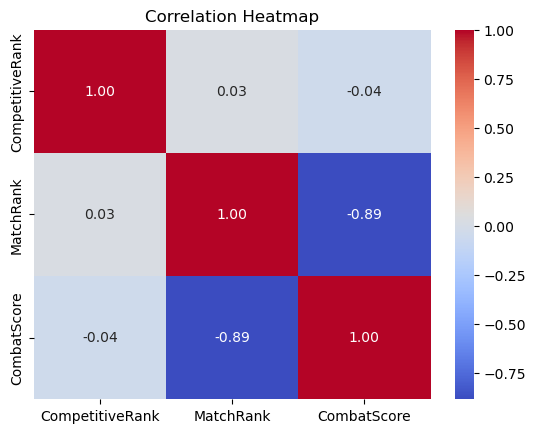

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = pdata[["CompetitiveRank", "MatchRank", "CombatScore"]].corr()

# Print correlation values
print(correlation_matrix)

# Visualize with heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


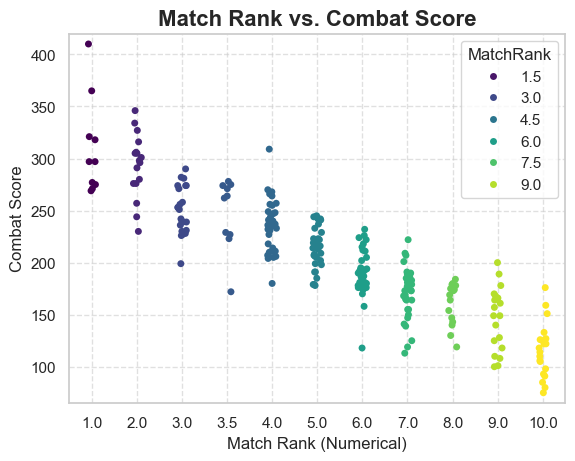

In [69]:

sns.stripplot(data=pdata,
                x="MatchRank",
                y="CombatScore",
                hue = "MatchRank",
                palette="viridis",
                s=5,
                edgecolor ="w",
                jitter = True)

plt.title("Match Rank vs. Combat Score", fontsize=16, weight='bold')
plt.xlabel("Match Rank (Numerical)", fontsize=12)
plt.ylabel("Combat Score", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(pdata["MatchRank"].min() - 1.5, pdata["MatchRank"].max() + 0.5)
plt.ylim(pdata["CombatScore"].min() - 10, pdata["CombatScore"].max() + 10)

plt.show()

